# Deep RL - Deep Q-Learning (DQN)

### Import required dependencies

In [1]:
from Practical08_Support.render import *
import random

import gym
import math
import random
import numpy as np
from collections import namedtuple
import copy
from itertools import count
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 


import matplotlib.pyplot as plt
from matplotlib import animation

import io
import base64
from IPython.display import HTML
from IPython.display import clear_output

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sample_agent = 'Practical08_Support/DQNagent_sample.pt'

def set_seed(env, seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    env.reset(seed = seed)

# 1. Lunar Lander Environment

In this notebook, we will use DQN to solve the [Lunar Lander](https://gym.openai.com/envs/LunarLander-v2/) environment.

![lunar-lander.gif](https://i.postimg.cc/sxmVCGwC/lunar-lander.gif)

## Task
Land the lunar lander on the landing pad at coordinates (0,0) in between the flags. You can control the luanr lander with its 3 engines, pointing downward, left, and right respectively.

## State Space
There are 8 state variables:

| State Variable | Description                        |
| :------------- | ---------------------------------: |
| x              | x coordinate of the lander         | 
| y              | y coordinate of the lander         | 
| $v_x$          | horizontal velocity of the lander  | 
| $v_y$          | vertical velocity of the lander    | 
| $\theta$       | the lander's orientation in space  | 
| $v_\theta$     | angular velocity of the lander     | 
| legs[0]        | 1 if left leg has contact, else 0  | 
| legs[1]        | 1 if right leg has contact, else 0 | 

## Action Space
There are 4 discrete actions (note: there is also a [continuous version](https://gym.openai.com/envs/LunarLanderContinuous-v2/) offered by OpenAI Gym):

| Num | Action            | 
| :-- | ----------------: |
| 0   | Do nothing        |
| 1   | Fire left engine  |
| 2   | Fire down engine  |
| 3   | Fire right engine |

## Rewards

- [Reward](https://github.com/openai/gym/blob/master/gym/envs/box2d/lunar_lander.py#L362) for moving from the top of the screen to landing pad and rest at zero velocity is about 100 to 140 points. Landing outside landing pad is possible. If lander moves away from landing pad it loses reward back. 
- Episode finishes if the lander crashes or comes to rest, receiving an additional -100 or +100 points. 
- Each leg having ground contact is +10. 
- Firing main engine is -0.3 points each frame. Fuel is infinite. 
- The environment is considered solved when the average return is greater than or equal to 200 points.


# 2. A random agent
Here we create an agent that takes random actions

In [2]:
class RandomAgent:

    def __init__(self, n, seed=None):
        self.rng = np.random.default_rng(seed)
        self.n = n

    def act(self, observation):
        # Sample one action in [0, n).
        return self.rng.integers(low=0, high=self.n)

RuntimeError: Requested MovieWriter (ffmpeg) not available

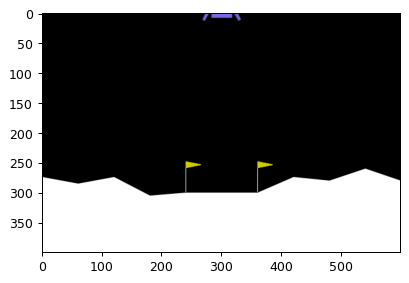

In [3]:
# Create an environment and an agent.
env = gym.make("LunarLander-v2", render_mode = "rgb_array")

agent = RandomAgent(env.action_space.n)

# Create animation of simulation.
frames, reward = simulate(agent, env, max_frames=500)
env.close()
html = animate(frames)

# Show the animation.
display(html)
print(f"Visualizing the random agent. Its reward is {reward}")

# 3. DQN Algorithm

Our implementation follows the algorithm proposed by *Mnih et .al* in  <a href="https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf">Playing Atari with Deep Reinforcement Learning</a> 

![dqn-replay-1.png](https://i.postimg.cc/6p6QtvbQ/dqn-replay-1.png)

We have decomposed the algorithm shown above into:
- A ReplayMemory class to represent and encode the Replay Buffer
- A DQN class to represent our NN function approximator
- An agent class which contains the learning logic of the algorithm
- A main loop in which transition tuples ('state', 'action', 'next_state', 'reward', 'done') are generated and added to the replay buffer. This loop also calls the agent ``optimize(.)`` method to train our approximator

## 4.1 Replay Buffer

Let's first define our representation of the replay buffer. To do so, we will use the class ``ReplayMemory`` shown below

**Note**: This implementation of the ReplayMemory class was taken from [***Pytorch DQN tutorial***](https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html)

In [4]:
# This tuple represents one observation in our environment
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward', 'done'))

class ReplayMemory:
    """
    A cyclic buffer of bounded size (capacity) that holds the transitions 
    observed recently. 
    
    It also implements a sample() method for selecting a random 
    batch of transitions for training.
    """
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        """Returns a minibatch of `Transition` randomly
        Args:
            batch_size (int): Size of mini-bach
        Returns:
            List[Transition]: Minibatch of `Transition`
        """
        return random.sample(self.memory, batch_size)

    def __len__(self):
        """Returns the length """
        return len(self.memory)

In [5]:
class DQN(nn.Module):
    """DQN Network
        Args:
        input_dim (int): `state` dimension.
        output_dim (int): Number of actions.
        hidden_dim (int): Hidden dimension in fully connected layer
    """
    def __init__(self, num_inputs=8, num_actions=4, hidden_dim_1=32, hidden_dim_2=32):
        super(DQN, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(num_inputs, hidden_dim_1),
            nn.ReLU(),
            nn.Linear(hidden_dim_1, hidden_dim_2),
            nn.ReLU(),
            nn.Linear(hidden_dim_2, num_actions)
        )
        
    def forward(self, x):
        """Returns a Q_value
        Args:
            x (torch.Tensor): `State` 2-D tensor of shape (n, num_inputs)
        Returns:
            torch.Tensor: Q_value, 2-D tensor of shape (n, num_actions)
        """
        return self.layers(x)

## 4.2 DQN Network

Let us now define the Multi Layer Perceptron network that will be used as the function approximator for the action-value function (q-function)

## 4.3 DQN Agent

This class contains the main steps of the Deep Q-learnig algorithm (highlighted in blue) in the image shown above.

**TODO**: 
- Complete the computation of the target value. Use the variables ``non_final_mask`` and ``non_final_next_states`` to do so. Similarly, the method ``get_next_q()`` returns the q-value of the maximum valued action at a given state, i.e., $\max_{a'}Q(s,a';\theta)$
- Compute the loss. That is the difference between the target q-values (``expected_q``) and the values estimated by the network (``predicted_q``). Use the attribute ``self.loss_fn(.)``.

Keep in mind how the targets are computed in the original algorithm

$$
\text{Set } y_j = 
\begin{cases}
r_j & \text{for terminal } \phi_{j+1} \\ 
r_j + \gamma \max_{a^{\prime}} Q(\phi_{j+1}, a^{\prime}; \theta) & \text{for non-terminal } \phi_{j+1}
\end{cases}
$$

In [6]:
class DQNAgent(object):
    """DQN Agent
    This class contains the main steps of the DQN algorithm
    
    Attributes:
    policy_net (DQN): Function approximator for our target q function
    loss_fn (MSELoss): Criterion that measures the mean squared error (squared L2 norm) 
                       between each element of the predicted and target q-values.
    optimizer (Adam): Stochastic gradient optimizer
    gamma (float): Discount factor
    """
    
    def __init__(self, input_dim=8, output_dim=4, 
                 hidden_dim_1=32, hidden_dim_2=32, gamma=0.99, lr=0.0001):
        """
        Define instance of DQNAgent
        Args:
        input_dim (int): `state` dimension.
        output_dim (int): Number of actions.
        hidden_dim (int): Hidden dimension in fully connected layer
        """
        
        
        self.policy_net = DQN(input_dim, output_dim, hidden_dim_1, hidden_dim_2).to(device)
                
        self.loss_fn = nn.MSELoss()
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=lr)
                
        self.gamma = torch.tensor(gamma).float().to(device)
        
    def get_action(self, state, action_space_dim, epsilon):
        """
        Select next action using epsilon-greedy policy
        Args:
        epsilon (float): Threshold used to decide whether a random or maximum-value action 
                         should be taken next
         Returns:
            int: action index
        """        
        with torch.no_grad():
            cur_q = self.policy_net(torch.from_numpy(state).float().to(device))
        q_value, action = torch.max(cur_q, axis=0)
        action = action if torch.rand(1,).item() > epsilon else torch.randint(0, action_space_dim, (1,)).item()
        action = torch.tensor([action]).to(device)
        return action
    
    def get_next_q(self, state):
        """Returns Q_value for maximum valued action at each state s
        Args:
            x (torch.Tensor): `State` 2-D tensor of shape (n, num_inputs)
        Returns:
            torch.Tensor: Q_value, 1 tensor of shape (n)
        """
        with torch.no_grad():
            next_q = self.policy_net(state)
        q, _ = torch.max(next_q, axis=1)
        return q
    
    def optimize(self, batch):
        """Computes `loss` and backpropagation
        Args:
            batch: List[Transition]: Minibatch of `Transition`
        Returns:
            float: loss value
        """
        
        state_batch = torch.stack(batch.state)
        action_batch = torch.stack(batch.action)
        reward_batch = torch.stack(batch.reward)
        next_state_batch = torch.stack(batch.next_state)
                
        # Compute a mask of non-final states and concatenate the batch elements
        # (a final state is the one after which the simulation ends)
        non_final_mask = torch.tensor(tuple(map(lambda s: s.item() is not True,
                                          batch.done)), device=device, dtype=torch.bool)
        non_final_next_states = torch.stack([s for i, s in enumerate(batch.next_state)
                                            if batch.done[i].item() is not True])

        # Compute predicted q-values
        predicted_q = self.policy_net(state_batch).gather(1, action_batch).reshape(1,-1)
        
        #TODO 1: Compute expected values for non-terminal and terminal states (this is our TD target) --
        target_q = 0
        target_q[non_final_mask] = 0
        #ENDTODO ---------------------------------------------------------------------------------------
        
        expected_q = reward_batch.reshape(1,-1)+(self.gamma * target_q)
        
        #TODO 2: Compute loss --------------------------------------------------------------------------
        loss = 0
        #ENDTODO ---------------------------------------------------------------------------------------
        
        # Use loss to compute gradient and update policy parameters through backpropagation
        self.optimizer.zero_grad()
        loss.backward(retain_graph=True)
        self.optimizer.step()
                
        return loss.item()


### Running Parameters

Note that here we are using number of frames to control the duration of the training. An episode contains varied number of frames and ends when the lander crashes or comes to rest.

In [8]:
# Define running hyper-parameters and epsilon training sequence
memory_capacity = 250
batch_size = 64
num_frames = 2500
epsilon_start = 1.0
epsilon_end = 0.05
epsilon_decay = 400
gamma = 0.99
lr = 1e-3
hidden_dim_1 = 32
hidden_dim_2 = 32
seed_value = 42

epsilon_by_step = lambda frame_idx: epsilon_end + (epsilon_start - epsilon_end) * math.exp(-1. * frame_idx / epsilon_decay)

Text(0, 0.5, 'Epsilon')

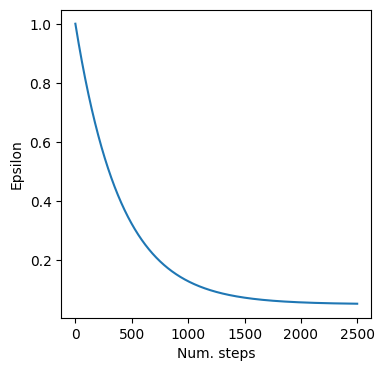

In [9]:
fig, ax = plt.subplots(figsize=(4, 4))

ax.plot([epsilon_by_step(i) for i in range(num_frames)])
ax.set_xlabel("Num. steps")
ax.set_ylabel("Epsilon")

### Main Loop and Replay Buffer Control

This is the main loop of our DQN implementation. Here we generate the samples added to the replay memory and train the agent using a batch sampled for the replay memory

### Let's now test our trained model

In [10]:
# Define varibles for plotting
losses_list, rewards_list, episode_len_list = [], [], []
list_epsilon = []

# Create instance of reply buffer
replay_buffer = ReplayMemory(memory_capacity)

# Create environment
env = gym.make("LunarLander-v2", render_mode = "rgb_array")
set_seed(env, seed_value)
n_actions = env.action_space.n
dim_state = env.observation_space.shape[0]

# Create agent
agent = DQNAgent(input_dim=dim_state, 
                 output_dim=n_actions, 
                 hidden_dim_1=hidden_dim_1, 
                 hidden_dim_2=hidden_dim_2, 
                 gamma=gamma, lr=lr)

# Reset environment and set all counters and cummulative varibles to zero
state, ep_len, losses, episode_reward = env.reset()[0], 0, 0, 0

for frame_idx in tqdm(range(1, num_frames + 1)):    
    # Get epsilon
    cur_epsilon = epsilon_by_step(frame_idx)
    
    # Sample action using e-greedy policy
    action = agent.get_action(state, n_actions, cur_epsilon)
    
    # Apply action and observe changes in the environment
    next_state, reward, done, truncated, _ = env.step(action.item())
    episode_reward += reward
    
    # Transform observation into Transition tuple
    t_s = torch.tensor(state).float().to(device)
    t_r = torch.tensor([reward]).float().to(device)
    t_ns = torch.tensor(next_state).float().to(device)
    t_a = action.to(device)
    t_done = torch.tensor([done or truncated]).bool().to(device)
                
    # Add new sample to replay buffer
    replay_buffer.push(t_s, t_a, t_ns, t_r, t_done)
    state = next_state
    
    ep_len += 1
    
    # If current episode has finished, reset environment and counters for next episode
    if (done or truncated):
        state = env.reset()[0]
        rewards_list.append(episode_reward)
        episode_len_list.append(ep_len)
        episode_reward, ep_len = 0, 0
    
    # If replay buffer has at least batch_size elements, sample batch and train approximator
    if len(replay_buffer) > batch_size:
        transitions = replay_buffer.sample(batch_size)
        batch = Transition(*zip(*transitions))
        loss = agent.optimize(batch)
        losses_list.append(loss)
    
    # Every 200 steps we plot the approximator's progress and performance
    if frame_idx % 200 == 0:
        plot(frame_idx, rewards_list, losses_list)

# Clear memory by freeing up the replay buffer
del replay_buffer

  3%|▎         | 64/2500 [00:00<00:00, 3369.38it/s]


TypeError: 'int' object does not support item assignment

In [14]:
# save the trained agent
file_name = 'DQNagent.pt'
torch.save(agent, file_name)
# file_name = sample_agent # uncomment this line to visualize performance of a sample DQN agent

#TODO: Please Ignore this ---------------------------------------------------------------

#ENDTODO --------------------------------------------------------------------------------

Trial No.0, return: -120.58666102729238
Trial No.1, return: -149.3941544651296
Trial No.2, return: -158.20334954076569
Trial No.3, return: -268.4313393621866
Trial No.4, return: -394.7429005271683
Trial No.5, return: -377.9774186911756
Trial No.6, return: -166.65560280730244
Trial No.7, return: -357.1265870766611
Trial No.8, return: -154.3300185902974
Trial No.9, return: -352.51671208812314

Average return -249.996 +- 105.38


RuntimeError: Requested MovieWriter (ffmpeg) not available

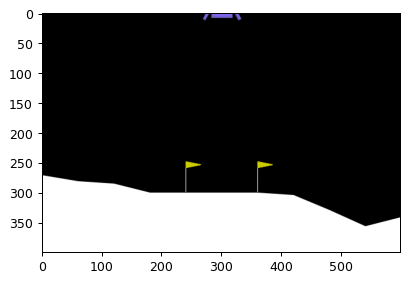

In [16]:
# Load the trained agent
file_name = file_name

agent = torch.load(file_name)
agent.policy_net.to(device)

# run n trials to examine how this agent performs
env = gym.make("LunarLander-v2", render_mode="rgb_array")
set_seed(env, seed_value)
n_trials = 10
list_rewards = []

wrapagent = DQNWrapper(agent)

# test on n trials 
visualize_trial_k = 7
for i in range(n_trials):

    # if you want to see the animation increase max_frames (slower)
    if i == visualize_trial_k:
        framebuffer, ep_return = simulate(wrapagent, env, max_frames=700)
    else:
        _, ep_return = simulate(wrapagent, env, max_frames=1)
    env.close()
    # Store the returns
    list_rewards.append(ep_return)
    print(f"Trial No.{i}, return: {ep_return}")

# summarize the trials
print(f'\nAverage return {np.round(np.mean(list_rewards),3)} +- {np.round(np.std(list_rewards), 3)}')
html = animate(framebuffer)
display(html)